In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.figure as fig
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
from datetime import datetime as dt
import re

In [2]:
# we only want the interval data from a single agency
# other ones for NM:  32000-2, 32000-3, 32000-901, 32000-4, 32000-61, 32000-8, 32000-9, 32000-18
agency = "34003-14"
# read the file in chunks, then append only the data that matches that agency
print(dt.now())
iter_csv = pd.read_csv('data/intervals.csv', iterator=True, chunksize=1000)
df = pd.concat([chunk[chunk['uniquename'] == agency] for chunk in iter_csv])
print(dt.now())

2019-01-18 12:15:40.675878
2019-01-18 12:15:57.146738


In [3]:
print("{} records for agency: {}".format(len(df), agency))
print("first 5:")
df.head()

4228 records for agency: 34003-14
first 5:


,Unnamed: 0,interval,origindex,timestamp,uniquename
2481352,2481352,922.0,4455.0,2018-09-13 02:03:15,34003-14
2481353,2481353,894.0,4950.0,2018-09-13 02:18:09,34003-14
2481354,2481354,917.0,5477.0,2018-09-13 02:33:26,34003-14
2481355,2481355,888.0,5917.0,2018-09-13 02:48:14,34003-14
2481356,2481356,880.0,6355.0,2018-09-13 03:02:54,34003-14


In [4]:
print("some basic stats:")
df["interval"].describe().apply(lambda x: format(x, '.2f'))

some basic stats:


count     4228.00
mean      1827.04
std       2142.35
min          2.00
25%        890.00
50%        913.00
75%       1798.00
max      28690.00
Name: interval, dtype: object

In [5]:
# the series of interest
series_of_interest = df["interval"]
# # of bins
bins_to_use = 100

In [6]:
# use the stats module to do the same histogram calculations as sns.distplot
# using the same bucketing parameters
bin_maxes, bin_edges, binnumber = stats.binned_statistic(series_of_interest, series_of_interest, statistic=max, bins=bins_to_use)

/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


<IPython.core.display.Javascript object>


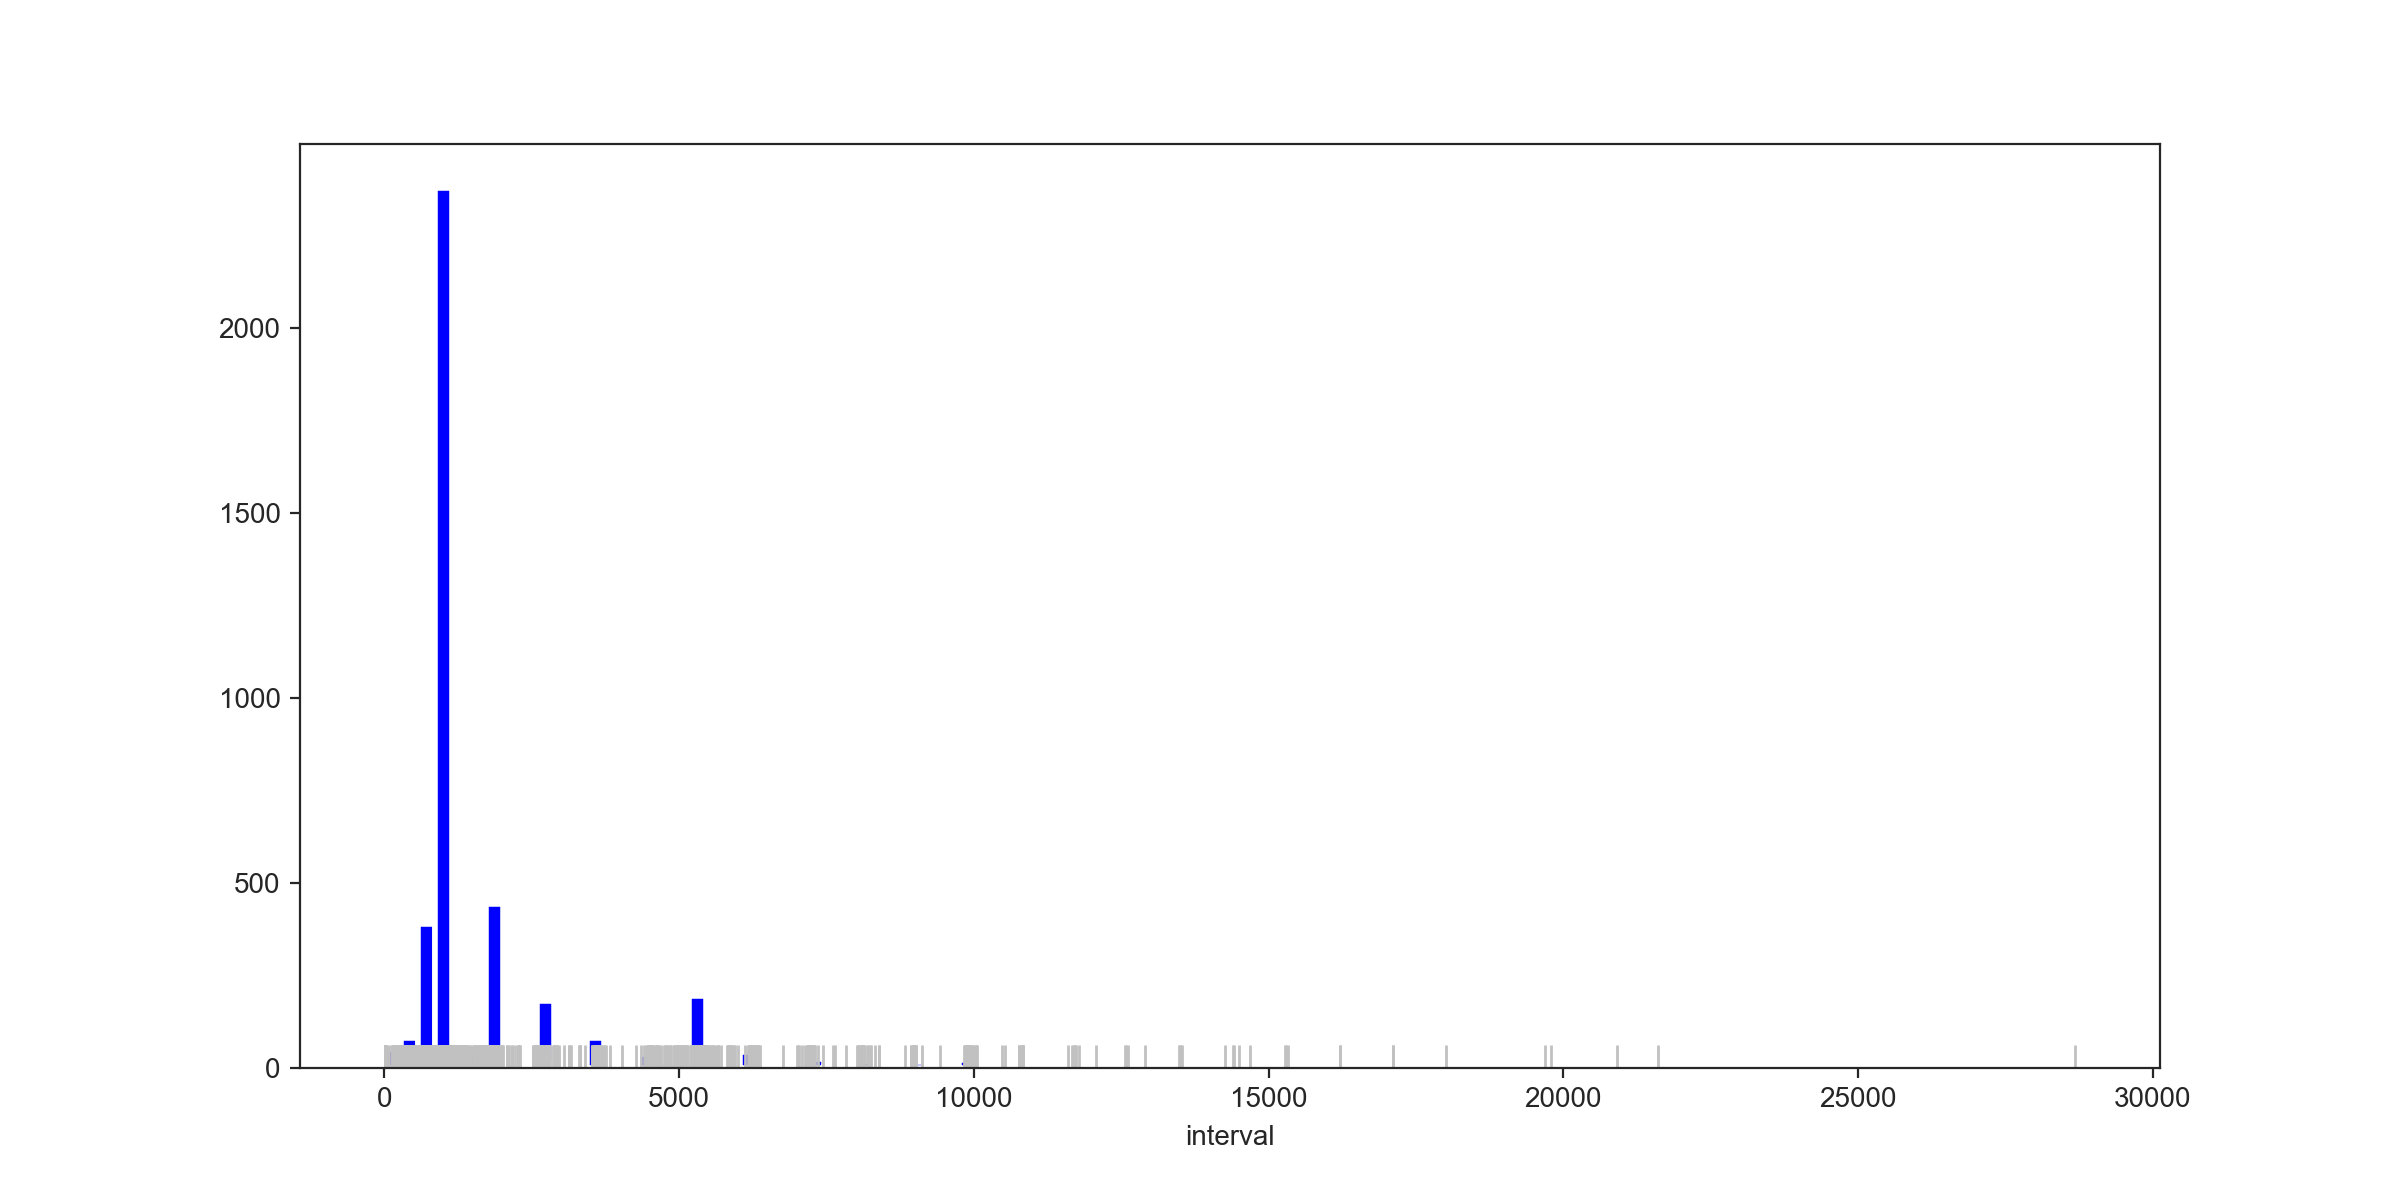

In [21]:
# graph the distribution of intervals using the .distplot function
# the .patches objects represent each graphed bin
sns.set_style('ticks')
fig = plt.figure()
ax = plt.subplot()

fig.set_size_inches(12, 6)
rugkws={"height": .025, "color": "999999"}
histkws={"linewidth": 2, "alpha": 1, "color": "b"}
p = sns.distplot(series_of_interest, bins=bins_to_use, rug=True, rug_kws=rugkws, hist_kws=histkws, kde=False).patches

annot = ax.annotate("", xy=(0,0), xytext=(-20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="black", ec="b", lw=2),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(bar):
    x = bar.get_x()+bar.get_width()/2.
    y = bar.get_y()+bar.get_height()
    annot.xy = (x,y)
    text = "{:.0f}@{:.0f} secs".format( y,x )
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        for bar in p:
            cont, ind = bar.contains(event)
            if cont:
                update_annot(bar)
                annot.set_visible(True)
                fig.canvas.draw_idle()
                return
    if vis:
        annot.set_visible(False)
        fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show();

In [9]:
# get the heights of the bins
heights = [item.get_height() for item in p]
# the highest
print("the highest bar is {}".format(max(heights)))
# sort the list, biggest first
sorted_heights = sorted(heights, reverse=True)
# top X
x = 5
print("info for top {}:".format(x))
for i in range(0,x):
    thebin = heights.index(sorted_heights[i])
    print("# {} - height: {}, bin: {}, max interval in bin: {}, right-edge of bin: {}".format(i+1,sorted_heights[i], thebin, bin_maxes[thebin], bin_edges[thebin+1]))
    

the highest bar is 2378.0
info for top 5:
# 1 - height: 2378.0, bin: 3, max interval in bin: 1148.0, right-edge of bin: 1149.52
# 2 - height: 444.0, bin: 6, max interval in bin: 2002.0, right-edge of bin: 2010.1599999999999
# 3 - height: 388.0, bin: 2, max interval in bin: 862.0, right-edge of bin: 862.64
# 4 - height: 194.0, bin: 18, max interval in bin: 5452.0, right-edge of bin: 5452.72
# 5 - height: 181.0, bin: 9, max interval in bin: 2868.0, right-edge of bin: 2870.8
